In [125]:
# It's a binary classification problem - predict if a passenger survived or not in space
# We will cover:
# - Data Preprocessing
# - Feature Engineering
# ...


In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.array_api import unique_counts

sns.set_style('darkgrid')

from imblearn.over_sampling import SMOTE
import itertools

import warnings
warnings.filterwarnings("ignore")

import plotly.express as px
import time

In [127]:
# SKLEARN
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [128]:
# Load the dataset
train = pd.read_csv('../data/spaceship-titanic/train.csv')
test = pd.read_csv('../data/spaceship-titanic/test.csv')

# SHapes and preview
print(f"Train set shape: {train.shape}\nTest set shape: {test.shape}")

Train set shape: (8693, 14)
Test set shape: (4277, 13)


In [129]:
train.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


In [130]:
train['Cabin']

0          B/0/P
1          F/0/S
2          A/0/S
3          A/0/S
4          F/1/S
          ...   
8688      A/98/P
8689    G/1499/S
8690    G/1500/S
8691     E/608/S
8692     E/608/S
Name: Cabin, Length: 8693, dtype: object

In [131]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [132]:
# Visualize missing values and everything else -> Have an informed decision for the next steps\

# Print missing values
print(f'Train set missing values: \n{train.isna().sum()}')

Train set missing values: 
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


In [133]:
print(f'Test set missing values: \n{test.isna().sum()}')

Test set missing values: 
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


In [134]:
# Duplicates
print(f'Train set duplicates: {train.duplicated().sum()}, Percentage({np.round(100 * train.duplicated().sum() / len(train), 1)}%)\n')
print(f'Test set duplicates: {test.duplicated().sum()}, Percentage({np.round(100 * test.duplicated().sum() / len(test), 1)}%)\n')

Train set duplicates: 0, Percentage(0.0%)

Test set duplicates: 0, Percentage(0.0%)



In [135]:
# Cardinality check
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

Text(0.5, 1.0, 'Target distribution')

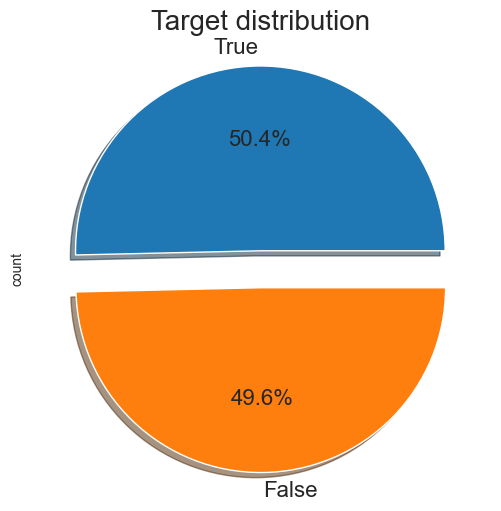

In [136]:
# EDA
# Visualize the target variable - is it balanced?
# Plot the target variable
plt.figure(figsize=(6, 6))

train['Transported'].value_counts().plot.pie(
    explode=(0.1, 0.1), autopct='%1.1f%%', 
    shadow=True, textprops={'fontsize': 16}
).set_title('Target distribution', fontsize=20)

Text(0.5, 0, 'Age')

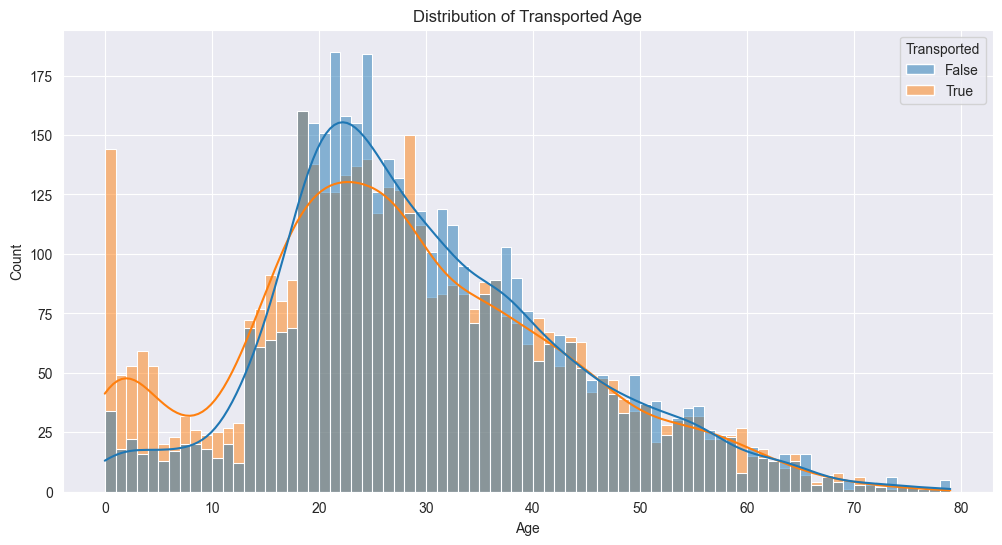

In [137]:
# CONTINUOUS FEATURES

plt.figure(figsize=(12, 6))

sns.histplot(data=train, x='Age', hue='Transported', kde=True, binwidth=1)

plt.title('Distribution of Transported Age')
plt.xlabel('Age')

In [138]:
# do some boolean masking to check the distribution of the ages with 0

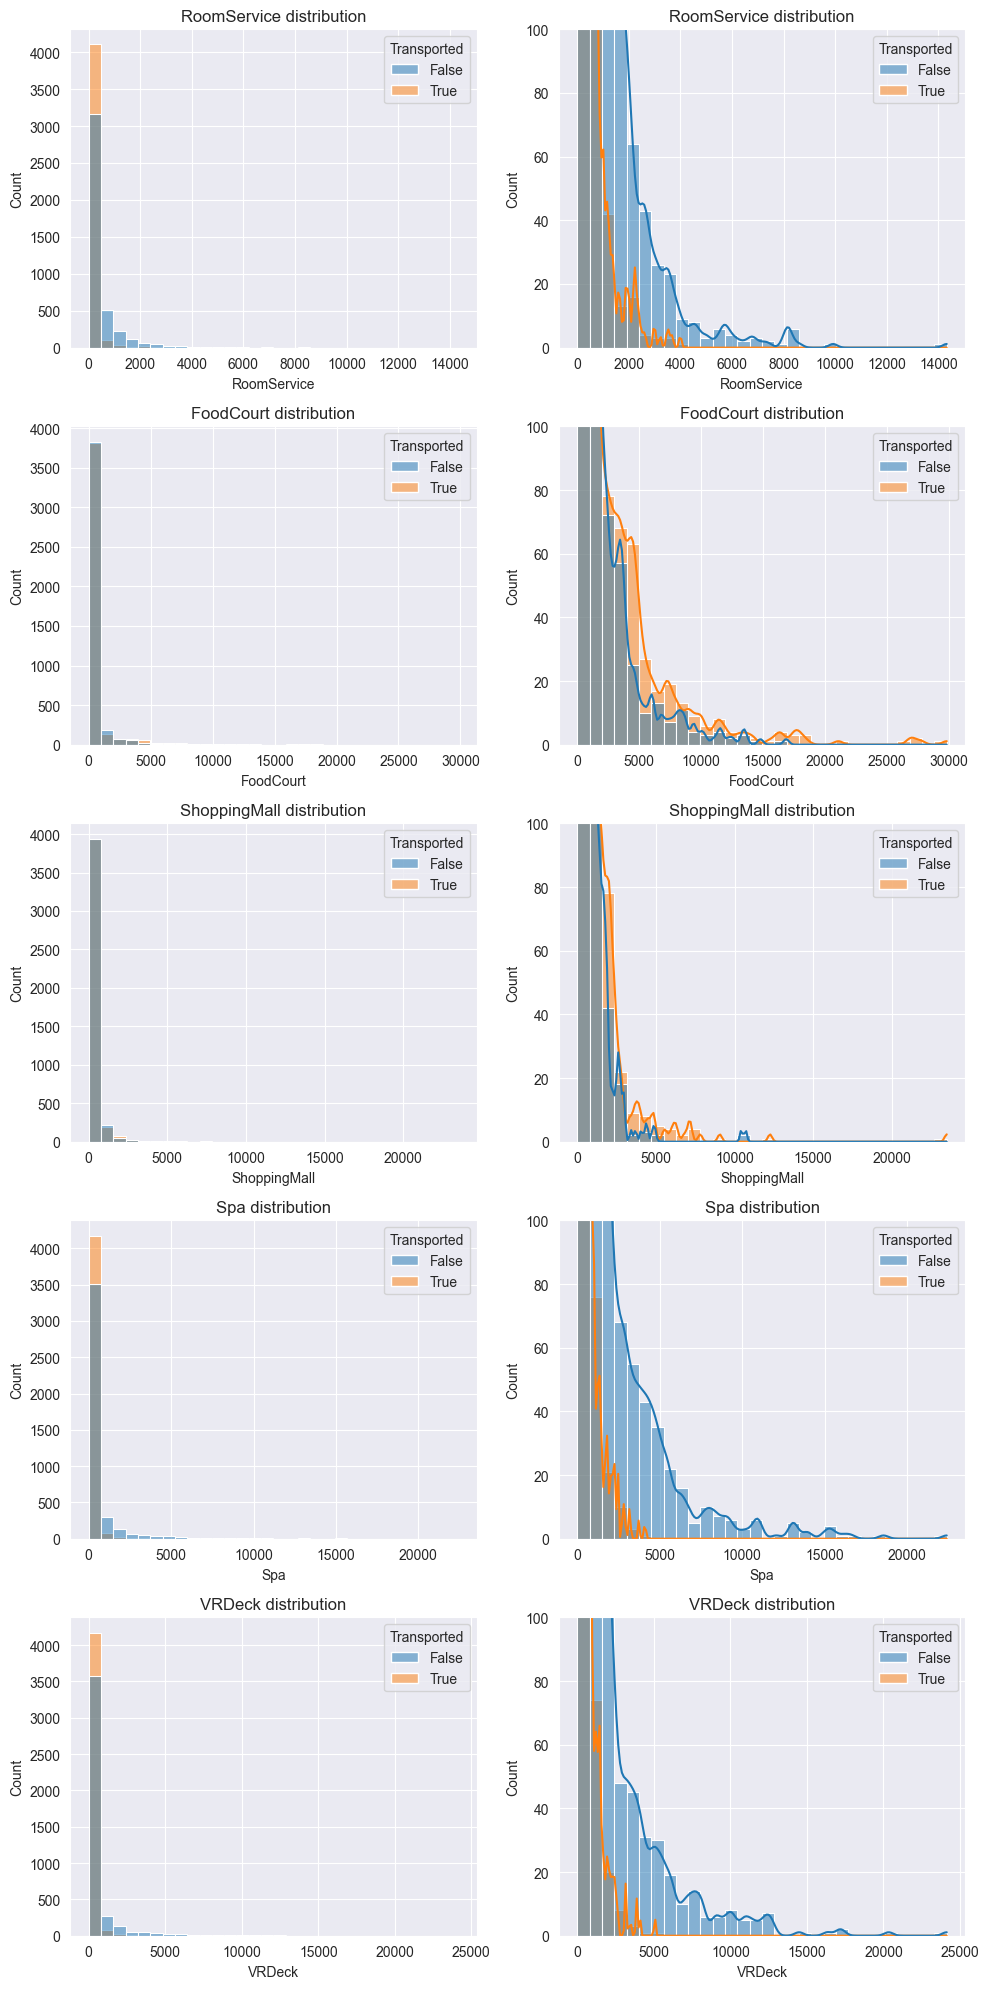

In [139]:
exp_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot the expenditure features
fig = plt.figure(figsize=(10, 20))

for i, var_name in enumerate(exp_features):
    # left plot
    ax = fig.add_subplot(5, 2, (2 * i) + 1)
    sns.histplot(data=train, x=var_name, hue='Transported', kde=False, bins=30, ax=ax)
    ax.set_title(f'{var_name} distribution')
    
    # right plot
    ax = fig.add_subplot(5, 2, (2 * i) + 2)
    # sns.histplot(data=train[train['Transported'] == 0], x=var_name, kde=True, bins=30, ax=ax)
    sns.histplot(data=train, x=var_name, hue='Transported', kde=True, bins=30, ax=ax)
    ax.set_title(f'{var_name} distribution')
    plt.ylim([0, 100])
    
fig.tight_layout()
plt.show()

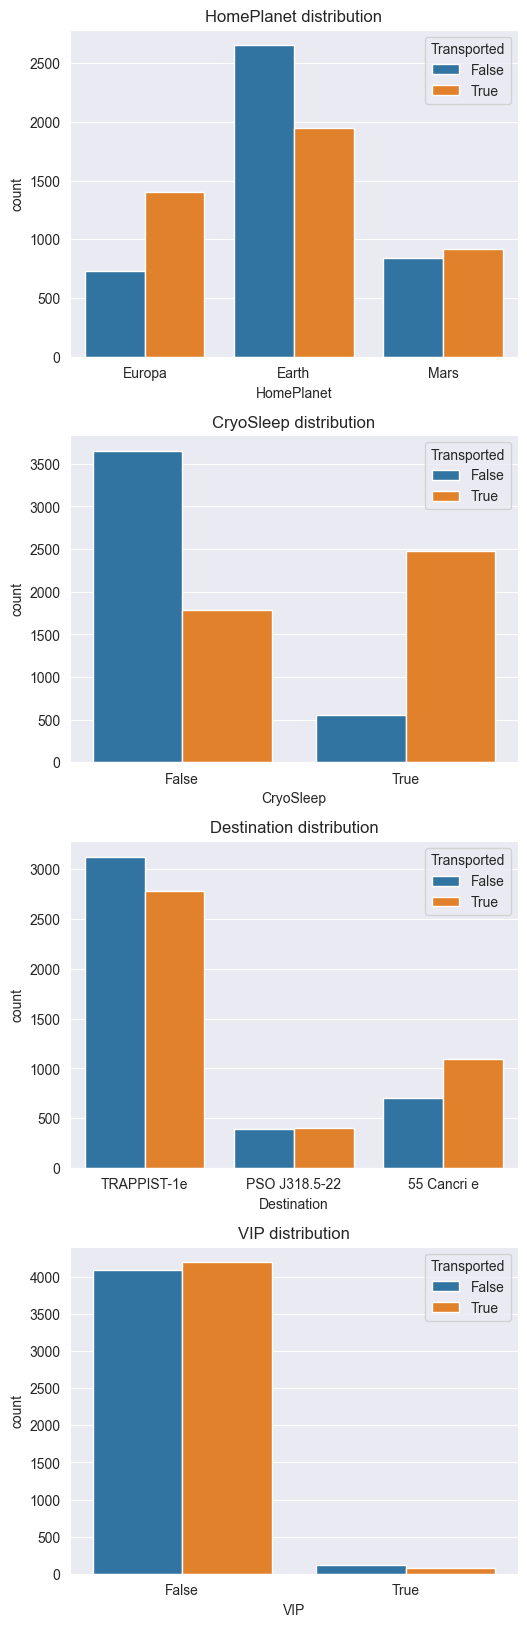

In [140]:
# Categorical features

categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig = plt.figure(figsize=(10, 20))

for i, var_name in enumerate(categorical_features):
    ax = fig.add_subplot(5, 2, (2 * i) + 1)
    sns.countplot(data=train, x=var_name, hue='Transported', ax=ax)
    ax.set_title(f'{var_name} distribution')
    
fig.tight_layout()
plt.show()

In [141]:
# Qualitative features

qualitative_features = ['Name', 'Cabin', 'PassengerId']

train[qualitative_features].head(10)

,Name,Cabin,PassengerId
0,Maham Ofracculy,B/0/P,0001_01
1,Juanna Vines,F/0/S,0002_01
2,Altark Susent,A/0/S,0003_01
3,Solam Susent,A/0/S,0003_02
4,Willy Santantines,F/1/S,0004_01
5,Sandie Hinetthews,F/0/P,0005_01
6,Billex Jacostaffey,F/2/S,0006_01
7,Candra Jacostaffey,G/0/S,0006_02
8,Andona Beston,F/3/S,0007_01
9,Erraiam Flatic,B/1/P,0008_01


In [142]:
# That's all for EDA

Text(0.5, 1.0, 'Distribution of Transported Age Group')

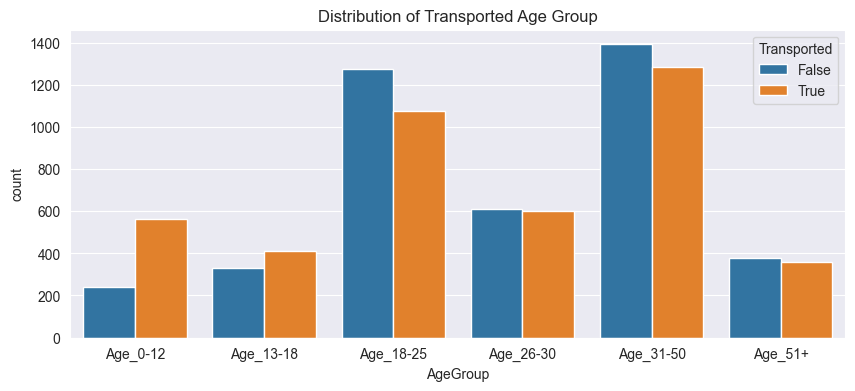

In [143]:
# FEATURE ENGINEERING

# Bin Age feature into groups

# new features - training set

train['AgeGroup'] = np.nan

train.loc[train['Age'] <= 12, 'AgeGroup'] = 'Age_0-12'
train.loc[(train['Age'] > 12) & (train['Age'] <= 18), 'AgeGroup'] = 'Age_13-18'
train.loc[(train['Age'] >= 18) & (train['Age'] <= 25), 'AgeGroup'] = 'Age_18-25'
train.loc[(train['Age'] > 25) & (train['Age'] <= 30), 'AgeGroup'] = 'Age_26-30'
train.loc[(train['Age'] > 30) & (train['Age'] <= 50), 'AgeGroup'] = 'Age_31-50'
train.loc[(train['Age'] > 50), 'AgeGroup'] = 'Age_51+'

# new features - test set
test['AgeGroup'] = np.nan

test.loc[test['Age'] <= 12, 'AgeGroup'] = 'Age_0-12'
test.loc[(test['Age'] > 12) & (test['Age'] <= 18), 'AgeGroup'] = 'Age_13-18'
test.loc[(test['Age'] >= 18) & (test['Age'] <= 25), 'AgeGroup'] = 'Age_18-25'
test.loc[(test['Age'] > 25) & (test['Age'] <= 30), 'AgeGroup'] = 'Age_26-30'
test.loc[(test['Age'] > 30) & (test['Age'] <= 50), 'AgeGroup'] = 'Age_31-50'
test.loc[(test['Age'] > 50), 'AgeGroup'] = 'Age_51+'

# plot distribution of the new features
plt.figure(figsize=(10, 4))
g = sns.countplot(data=train, x='AgeGroup', hue='Transported', order=['Age_0-12', 'Age_13-18', 'Age_18-25', 'Age_26-30', 'Age_31-50', 'Age_51+'])
plt.title('Distribution of Transported Age Group')

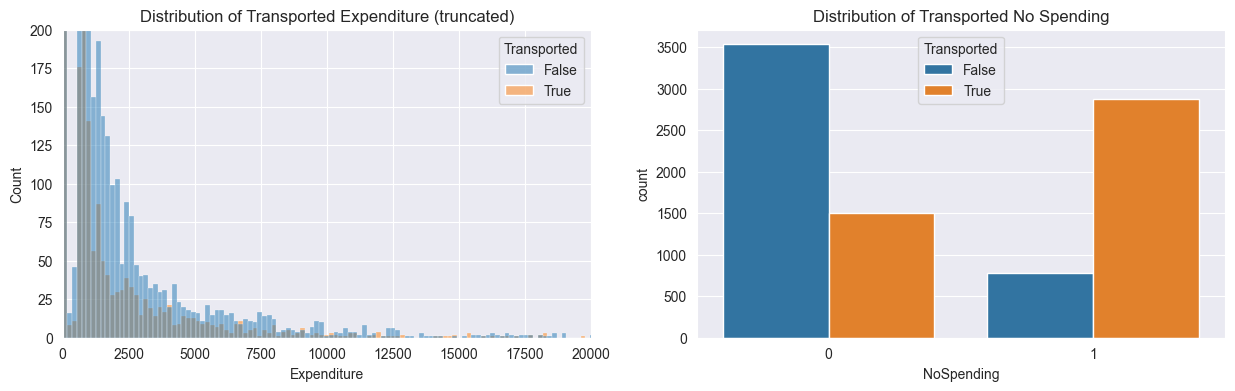

In [144]:
# New features - Training set

train['Expenditure'] = train[exp_features].sum(axis=1)
train['NoSpending'] = (train['Expenditure'] == 0).astype(int)

# New features - Training set

test['Expenditure'] = test[exp_features].sum(axis=1)
test['NoSpending'] = (test['Expenditure'] == 0).astype(int)

# plot distribution of the new features !!
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
# It's good to introduce the number of bins when using a histogram, it's a good practice - but it's okay without it for a countplot
sns.histplot(data=train, x='Expenditure', hue='Transported', bins=200)
plt.title('Distribution of Transported Expenditure (truncated)')
plt.ylim([0, 200])
plt.xlim([0, 20000])

plt.subplot(1, 2, 2)
sns.countplot(data=train, x='NoSpending', hue='Transported')
plt.title('Distribution of Transported No Spending')
fig.tight_layout()

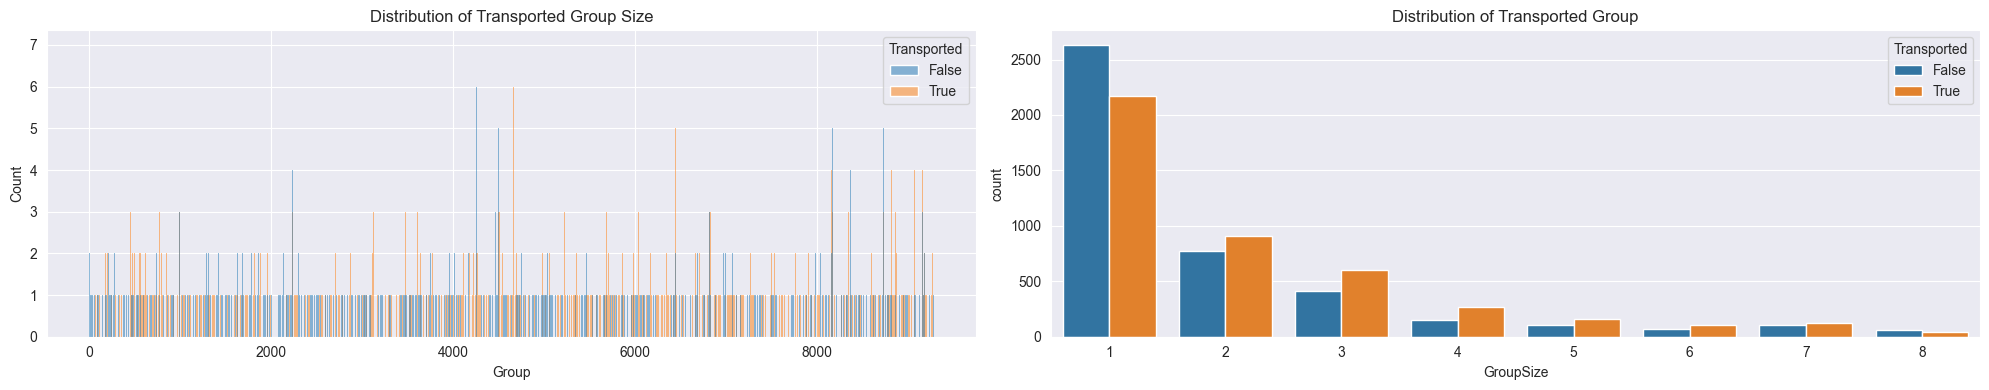

In [145]:
# Extract the passenger group and the group size from the passneger ID

# New features - group
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

# New features - group size

# TODO: Homework - Explain the lambda functions

"""
* Concatenates the group columns from both train and test sets into one series (group members might be split between train and test sets)
* Uses value_counts() to count the occurrences of each group in the concatenated series
* Maps the group size back to the original group in the train and test sets - [x] in the end retrieves the count for that specific group number

"""

train['GroupSize'] = train['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])
test['GroupSize'] = test['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])

# plot distribution of the new features
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
sns.histplot(data=train, x='Group', hue='Transported', binwidth=1)
plt.title('Distribution of Transported Group Size')

plt.subplot(1, 2, 2)
sns.countplot(data=train, x='GroupSize', hue='Transported')
plt.title('Distribution of Transported Group')

plt.tight_layout()

In [146]:
# Try to reduce dimensionality as much as possible, while keeping the most important features

(0.0, 3000.0)

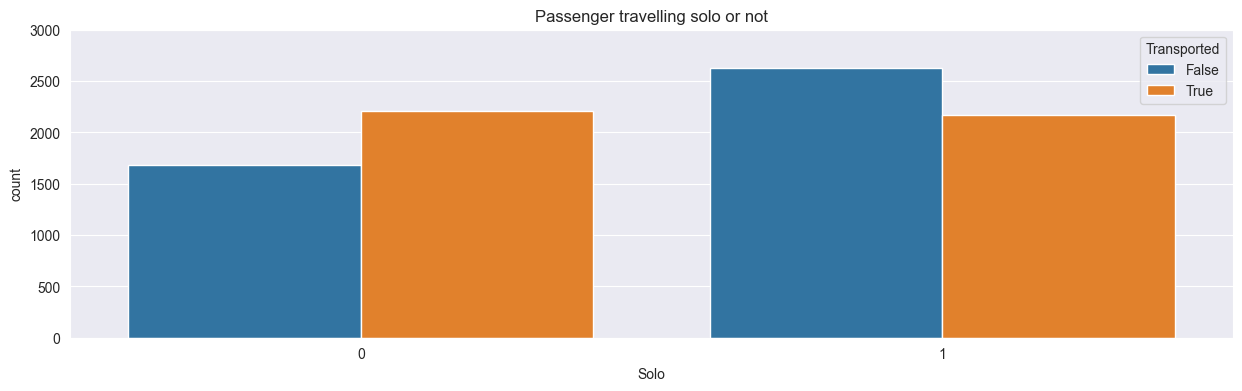

In [147]:
# New feature 

train['Solo'] = (train['GroupSize'] == 1).astype(int)
test['Solo'] = (test['GroupSize'] == 1).astype(int)

# plot distribution of the new features
plt.figure(figsize=(15, 4))
sns.countplot(data=train, x='Solo', hue='Transported')
plt.title('Passenger travelling solo or not')
plt.ylim([0, 3000])

In [148]:
# New feature - Cabin

# Cabin Location

# Replace NaNs with outliers (za sada)
train['Cabin'].fillna('Z/9999/Z', inplace=True)
test['Cabin'].fillna('Z/9999/Z', inplace=True)

# New features - Training set
train['CabinDeck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['CabinNum'] = train['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train['CabinSide'] = train['Cabin'].apply(lambda x: x.split('/')[2])

# New features - Test set
test['CabinDeck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['CabinNum'] = test['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test['CabinSide'] = test['Cabin'].apply(lambda x: x.split('/')[2])

In [149]:
# Put the NaNs back
train.loc[train['CabinDeck'] == 'Z', 'CabinDeck'] = np.nan
test.loc[test['CabinDeck'] == 'Z', 'CabinDeck'] = np.nan

train.loc[train['CabinNum'] == 9999, 'CabinNum'] = np.nan
test.loc[test['CabinNum'] == 9999, 'CabinNum'] = np.nan

train.loc[train['CabinSide'] == 'Z', 'CabinSide'] = np.nan
test.loc[test['CabinSide'] == 'Z', 'CabinSide'] = np.nan

In [150]:
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

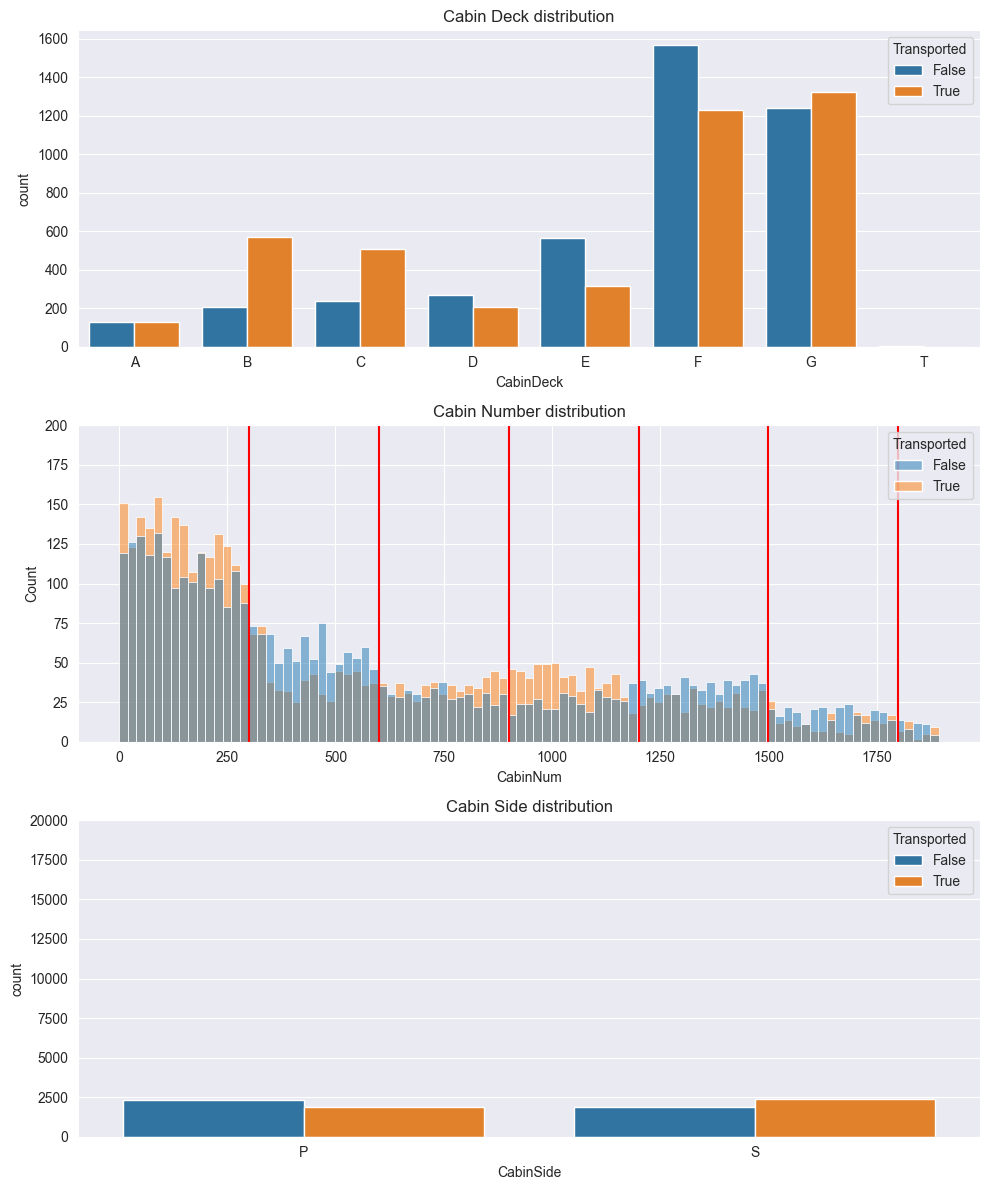

In [151]:
# Plot the distribution
plt.figure(figsize=(10, 12))
plt.subplot(3, 1, 1)
sns.countplot(data=train, x='CabinDeck', hue='Transported', order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])
plt.title('Cabin Deck distribution')

plt.subplot(3, 1, 2)
sns.histplot(data=train, x='CabinNum', hue='Transported', binwidth=20)
plt.vlines(300, ymin=0, ymax=200, color='red')
plt.vlines(600, ymin=0, ymax=200, color='red')
plt.vlines(900, ymin=0, ymax=200, color='red')
plt.vlines(1200, ymin=0, ymax=200, color='red')
plt.vlines(1500, ymin=0, ymax=200, color='red')
plt.vlines(1800, ymin=0, ymax=200, color='red')
plt.title('Cabin Number distribution')
plt.ylim([0, 200])

plt.subplot(3, 1, 3)
sns.countplot(data=train, x='CabinSide', hue='Transported', order=['P', 'S'])
plt.title('Cabin Side distribution')
plt.ylim([0, 20000])

plt.tight_layout()

# TODO: Homework - Check the exact number of people in Cabin Deck T

In [152]:
t_deck_counts = train[train['CabinDeck'] == 'T']['Transported'].value_counts()

print(f"Cabin Deck T counts: {t_deck_counts}")

Cabin Deck T counts: Transported
False    4
True     1
Name: count, dtype: int64


Text(0.5, 1.0, 'Cabin Regions distribution')

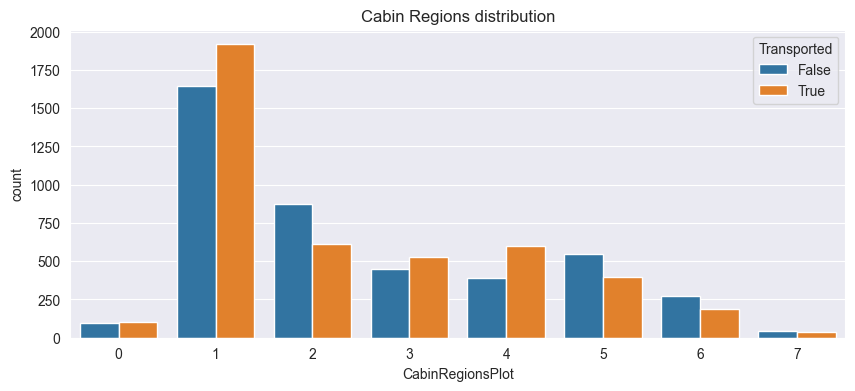

In [153]:
# New feature - training set
train['CabinRegion1'] = (train['CabinNum'] < 300).astype(int)
train['CabinRegion2'] = ((train['CabinNum'] >= 300) & (train['CabinNum'] < 600)).astype(int)
train['CabinRegion3'] = ((train['CabinNum'] >= 600) & (train['CabinNum'] < 900)).astype(int)
train['CabinRegion4'] = ((train['CabinNum'] >= 900) & (train['CabinNum'] < 1200)).astype(int)
train['CabinRegion5'] = ((train['CabinNum'] >= 1200) & (train['CabinNum'] < 1500)).astype(int)
train['CabinRegion6'] = ((train['CabinNum'] >= 1500) & (train['CabinNum'] < 1800)).astype(int)
train['CabinRegion7'] = (train['CabinNum'] >= 1800).astype(int)

# New feature - test set
test['CabinRegion1'] = (test['CabinNum'] < 300).astype(int)
test['CabinRegion2'] = ((test['CabinNum'] >= 300) & (test['CabinNum'] < 600)).astype(int)
test['CabinRegion3'] = ((test['CabinNum'] >= 600) & (test['CabinNum'] < 900)).astype(int)
test['CabinRegion4'] = ((test['CabinNum'] >= 900) & (test['CabinNum'] < 1200)).astype(int)
test['CabinRegion5'] = ((test['CabinNum'] >= 1200) & (test['CabinNum'] < 1500)).astype(int)
test['CabinRegion6'] = ((test['CabinNum'] >= 1500) & (test['CabinNum'] < 1800)).astype(int)
test['CabinRegion7'] = (test['CabinNum'] >= 1800).astype(int)

# plot distribution of the new features
plt.figure(figsize=(10, 4))
train['CabinRegionsPlot'] = (train['CabinRegion1'] + 2 * train['CabinRegion2'] + 3 * train['CabinRegion3'] + 4 * train['CabinRegion4'] + 5 * train['CabinRegion5'] + 6 * train['CabinRegion6'] + 7 * train['CabinRegion7'])

# TODO: Cabin Regions Plot column - why did we do the multiplication and adding?

"""
* Since each CabinRegion is more like a binary feature, we can use the multiplication to create a new feature that represents the Cabin Region
"""

sns.countplot(data=train, x='CabinRegionsPlot', hue='Transported')
plt.title('Cabin Regions distribution')


In [154]:
train.drop('CabinRegionsPlot', axis=1, inplace=True)

In [155]:
# replace NaNs with outliers (za sada)
train['Name'].fillna(' Unknown Unknown', inplace=True)
test['Name'].fillna(' Unknown Unknown', inplace=True)

# New feature - Surname
train['Surname'] = train['Name'].apply(lambda x: x.split(' ')[1])
test['Surname'] = test['Name'].apply(lambda x: x.split(' ')[1])

# New feature - Family Size
train['FamilySize'] = train['Surname'].map(lambda x: pd.concat([train['Surname'], test['Surname']]).value_counts()[x])
test['FamilySize'] = test['Surname'].map(lambda x: pd.concat([train['Surname'], test['Surname']]).value_counts()[x])

# Put the NaNs back - TRAIN
train.loc[train['Surname'] == 'Unknown', 'Surname'] = np.nan
train.loc[train['FamilySize'] > 100, 'FamilySize'] = np.nan

# Put the NaNs back - TEST
train.loc[train['Surname'] == 'Unknown', 'Surname'] = np.nan
train.loc[train['FamilySize'] > 100, 'FamilySize'] = np.nan

# Drop the Name column
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

Text(0.5, 1.0, 'Family Size distribution')

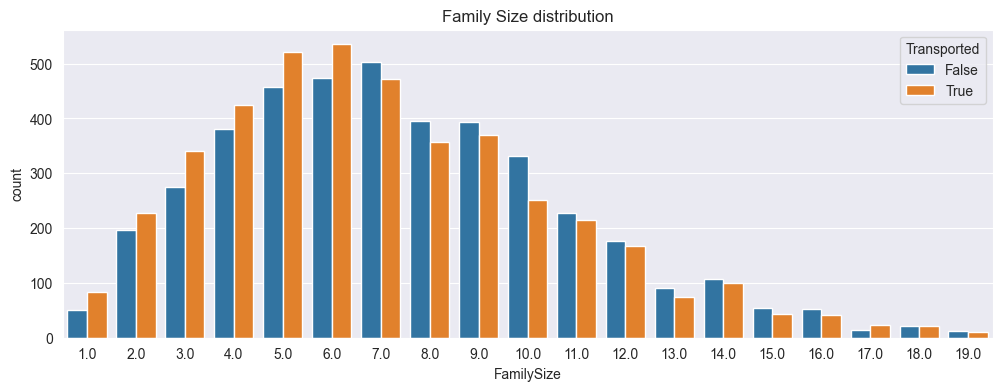

In [156]:
plt.figure(figsize=(12, 4))
sns.countplot(data=train, x="FamilySize", hue='Transported')
plt.title('Family Size distribution')

In [157]:
# Missing values
# Combine the train and test sets

y = train['Transported'].copy().astype(int)
X = train.drop('Transported', axis=1).copy()

# Dataframe concatenation
data = pd.concat([X, test], axis=0).reset_index(drop=True)

In [158]:
# Explore missing values

na_cols = data.columns[data.isna().any()].tolist()
na_cols

['HomePlanet',
 'CryoSleep',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'AgeGroup',
 'CabinDeck',
 'CabinNum',
 'CabinSide',
 'Surname',
 'FamilySize']

In [159]:
missing_values = pd.DataFrame(data[na_cols].isnull().sum(), columns=['Number Missing Values'])

missing_values['Percentage Missing Values'] = np.round(missing_values['Number Missing Values'] / len(data) * 100, 2)

missing_values

,Number Missing Values,Percentage Missing Values
HomePlanet,288,2.22
CryoSleep,310,2.39
Destination,274,2.11
Age,270,2.08
VIP,296,2.28
RoomService,263,2.03
FoodCourt,289,2.23
ShoppingMall,306,2.36
Spa,284,2.19
VRDeck,268,2.07


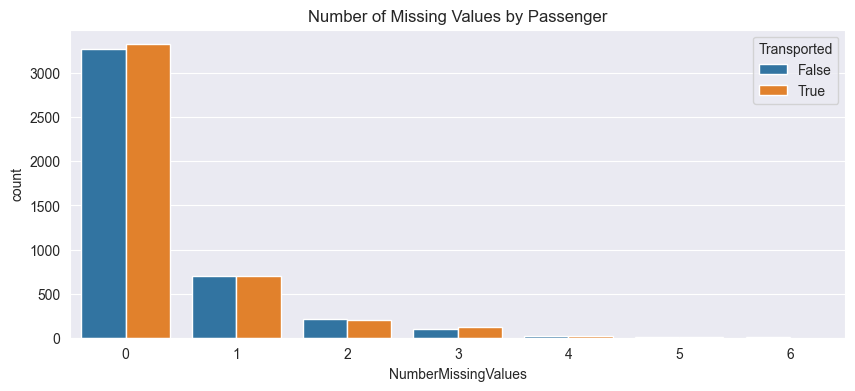

In [160]:
# Countplot of number of missing values by passenger

train['NumberMissingValues'] = train.isna().sum(axis=1)
plt.figure(figsize=(10, 4))
sns.countplot(data=train, x='NumberMissingValues', hue='Transported')

plt.title('Number of Missing Values by Passenger')
train.drop('NumberMissingValues', axis=1, inplace=True)

In [161]:
# Home Planet and Group

GHB_gb = data.groupby(['Group', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
GHB_gb.head()

HomePlanet,Earth,Europa,Mars
Group,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,2.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0


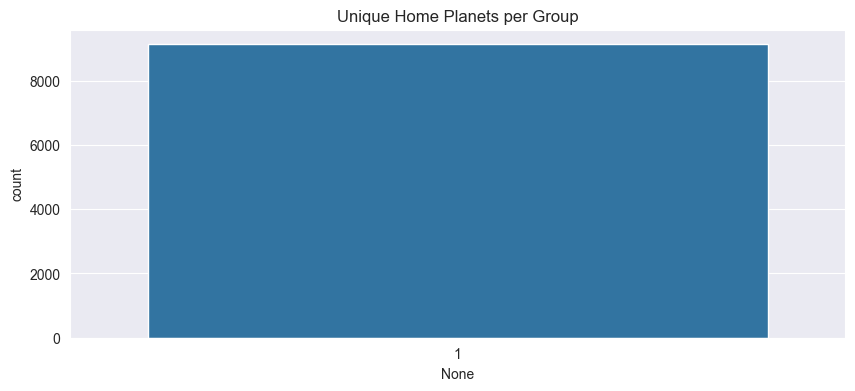

In [162]:
# Countplot of Unique values

GHB_gb = GHB_gb.apply(pd.to_numeric, errors='coerce')

# Count Unique home planets per group

unique_counts = (GHB_gb > 0).sum(axis=1)

# Plot the unique counts
plt.figure(figsize=(10, 4))
sns.countplot(x=unique_counts)
plt.title('Unique Home Planets per Group')
plt.show()

In [163]:
# Missing values

HP_before = data['HomePlanet'].isna().sum()

# Fill the missing values with the most common home planet in the group
# Passengers with missing home planet and in a grop with known home planet
GHB_index = data[data['HomePlanet'].isna()][data[data['HomePlanet'].isna()]['Group'].isin(GHB_gb.index)].index
# TODO: Find out what the fuck this does

# Fill the missing values
data.loc[GHB_index, 'HomePlanet'] = data.iloc[GHB_index, :]['Group'].map(lambda x: GHB_gb.idxmax(axis=1)[x])
print(f"HomePlanet missing values before: {HP_before}")
print(f"HomePLanet missing values after: {data['HomePlanet'].isna().sum()}")

HomePlanet missing values before: 288
HomePLanet missing values after: 157


<Axes: xlabel='CabinDeck', ylabel='HomePlanet'>

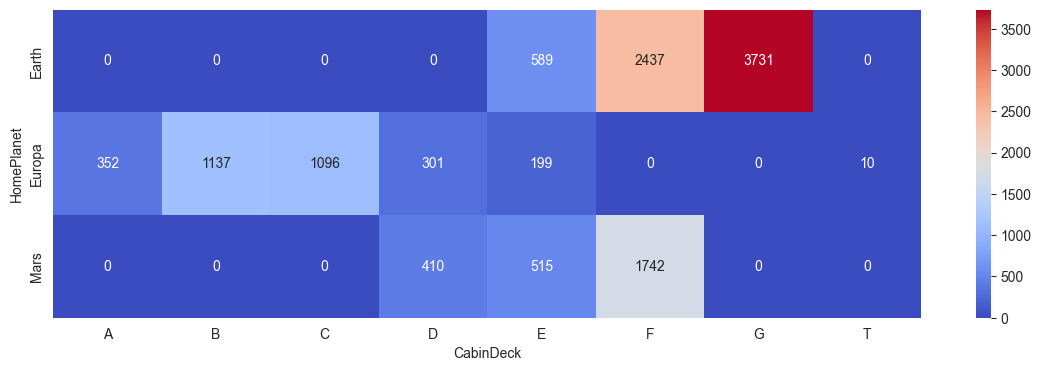

In [164]:
# HomePlanet and CabinDeck

# Joint distributions of CabinDeck and HomePlanet
CDHP_gb = data.groupby(['CabinDeck', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# heatmap
plt.figure(figsize=(14, 4))
sns.heatmap(CDHP_gb.T, annot=True, fmt='g', cmap="coolwarm")

In [165]:
# Missing values before
HP_before = data['HomePlanet'].isna().sum()

# decks, A, B, C, T came from Europa
data.loc[(data['HomePlanet'].isna()) & (data['CabinDeck'].isin(["A", "B", "C", "T"])), 'HomePlanet'] = 'Europa'

# deck G came from earth
data.loc[(data['HomePlanet'].isna()) & (data['CabinDeck'] == 'G'), 'HomePlanet'] = 'Earth'

# print missing values
print(f"HomePlanet missing values before: {HP_before}")
print(f"HomePLanet missing values after: {data['HomePlanet'].isna().sum()}")

HomePlanet missing values before: 157
HomePLanet missing values after: 94


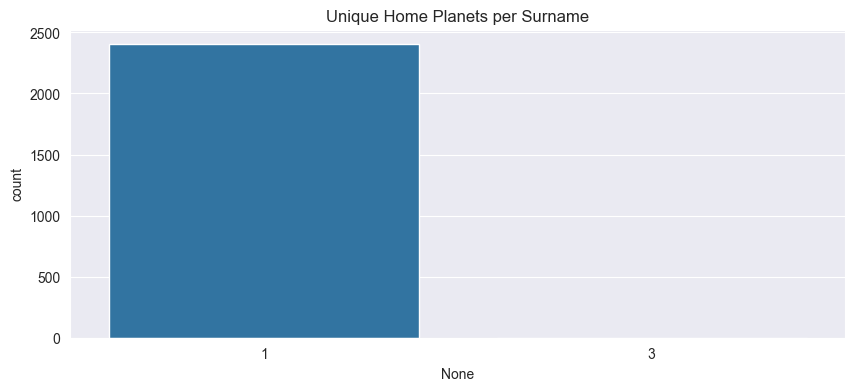

In [166]:
# Home planet and surname
SHP_gb = data.groupby(['Surname', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# ensure SHP_gb is numeric
SHP_gb = SHP_gb.apply(pd.to_numeric, errors='coerce')

# Count unique home planets per surname
unique_counts = (SHP_gb > 0).sum(axis=1)

# plot
plt.figure(figsize=(10, 4))
sns.countplot(x=unique_counts)
plt.title('Unique Home Planets per Surname')
plt.show()

In [167]:
# missing values from before
HP_bef = data['HomePlanet'].isna().sum()

# passengers with missing home planet and in a family with known home planet
SHP_index = data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Surname']).isin(SHP_gb.index)].index

# fill missing values
data.loc[SHP_index, 'HomePlanet'] = data.iloc[SHP_index,:]['Surname'].map(lambda x : SHP_gb.idxmax(axis=1)[x])

# print missing values
print('HomePlanet missing values before:', HP_bef)
print('HomePlanet missing values after:', data['HomePlanet'].isna().sum())

HomePlanet missing values before: 94
HomePlanet missing values after: 9


In [168]:
# only 10 home planets missing values are left - let's look at them 
data[data['HomePlanet'].isna()][['PassengerId', 'HomePlanet', 'Destination']]

,PassengerId,HomePlanet,Destination
2274,2443_01,NaN,TRAPPIST-1e
2631,2817_01,NaN,TRAPPIST-1e
3091,3331_01,NaN,TRAPPIST-1e
4548,4840_01,NaN,TRAPPIST-1e
5762,6108_01,NaN,TRAPPIST-1e
8969,0616_01,NaN,TRAPPIST-1e
10583,4052_01,NaN,TRAPPIST-1e
11913,7065_01,NaN,TRAPPIST-1e
12725,8775_01,NaN,TRAPPIST-1e


<Axes: xlabel='HomePlanet', ylabel='Destination'>

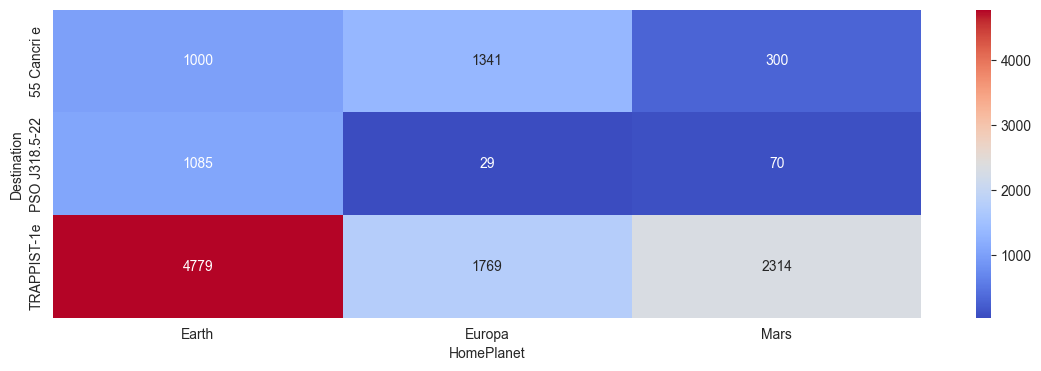

In [170]:
# Home planet and destination
HPD_gb = data.groupby(['Destination', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# heatmap
plt.figure(figsize=(14, 4))
sns.heatmap(HPD_gb, annot=True, fmt='g', cmap="coolwarm")

In [171]:
HP_before = data['HomePlanet'].isna().sum()

# fill missing values
data.loc[(data['HomePlanet'].isna() & ~(data['CabinDeck'] == 'D'), 'HomePlanet')] = 'Earth'
data.loc[(data['HomePlanet'].isna() & (data['CabinDeck'] == 'D'), 'HomePlanet')] = 'Mars'

# print missing values
print(f"HomePlanet missing values before: {HP_before}")
print(f"HomePLanet missing values after: {data['HomePlanet'].isna().sum()}")

HomePlanet missing values before: 9
HomePLanet missing values after: 0


In [172]:
D_before = data['Destination'].isna().sum()

# fill missing values with the most common destination in the group - mean, median or mode
data.loc[(data['Destination'].isna()), 'Destination'] = "TRAPPIST-1e"

# print missing values
print(f"Destination missing values before: {D_before}")
print(f"Destination missing values after: {data['Destination'].isna().sum()}")

Destination missing values before: 274
Destination missing values after: 0


In [ ]:
# Surname and Group